# Movie Mate: Find Your Next Cinematic Match

## Objective: Build and evaluate recommendation engines to predict user movie preferences.

### Introduction

Ditch the endless scrolling! Our data-powered engine finds your next cinematic soulmate based on your unique movie taste.

Our objective is to leverage the power of data science to build intelligent recommendation engines that can predict which superhero movies you'll enjoy the most. By analyzing your movie preferences and incorporating the "Batman vs. Superman" theme, we aim to create a personalized recommendation experience that caters to your specific tastes.

The cornerstone of our recommendation system is the MovieLens dataset. This renowned dataset provides a treasure trove of user ratings for countless movies across various genres. The richness of this data allows us to understand user preferences and identify patterns that can be harnessed for movie recommendations.

Get ready to embark on a thrilling journey as we explore the intersection of data science and superhero fandom!

### Data Preparation

#### Looking at the columns

In [3]:
import pandas as pd

folder_path = "./data"
file_names = ["tag", "rating", "movie", "link", "genome_tags", "genome_scores"]

print("Columns in each data source:")

for file_name in file_names:
    df = pd.read_csv(folder_path + "/" + file_name + ".csv")
    print("File name: " + file_name)
    print(df.head())

Columns in each data source:
File name: tag
   userId  movieId            tag            timestamp
0      18     4141    Mark Waters  2009-04-24 18:19:40
1      65      208      dark hero  2013-05-10 01:41:18
2      65      353      dark hero  2013-05-10 01:41:19
3      65      521  noir thriller  2013-05-10 01:39:43
4      65      592      dark hero  2013-05-10 01:41:18
File name: rating
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40
File name: movie
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

  

I will use the following data for the 3 approaches, 

1. Collaborative (user based): movie rating data
2. Collaborative (movie based): movie rating data
3. Content based : genome scores data

#### Checking for missing or incomplete data

##### Movie rating data

In [29]:
import pandas as pd

data_path = "./data/rating.csv"
rating_df = pd.read_csv(data_path)
print(rating_df.head())

   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40


Questions i'm concerned with:
1. What is the total number of movies?
2. What is the total number of users?
3. What is the average number of movies rated by a user?
4. What is the average number of ratings per movie?

In [3]:
print(rating_df.nunique())

userId         138493
movieId         26744
rating             10
timestamp    15351121
dtype: int64


In [14]:
user_movie_count = rating_df.groupby('userId')['movieId'].nunique()
print(user_movie_count.describe())

count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: movieId, dtype: float64


In [15]:
movie_user_count = rating_df.groupby('movieId')['userId'].nunique()
print(movie_user_count.describe())

count    26744.000000
mean       747.841123
std       3085.818268
min          1.000000
25%          3.000000
50%         18.000000
75%        205.000000
max      67310.000000
Name: userId, dtype: float64


### Collaborative Filtering

##### User-based Collaborative Filtering (CF):

<b>Concept:</b> User-based CF identifies users with similar taste in movies (neighbors) and recommends movies those neighbors enjoyed but the target user hasn't seen yet.
<b>Similarity Calculation:</b> We can calculate pairwise similarity between users using adjusted cosine similarity. This measures how closely aligned their rating vectors are, considering the direction of their ratings

<b>Considerations:</b>
- We are using adjusted cosine since it's possible some users tend to rate enverything higher and some everything lower.
- There exists a likely scenario that there isn't much overlap between the movies 2 people have rated. This is one of the major downsides of this kind of approach.

  Although, a case can be made that users not having rated the same movies does carry some significance from case to case.

  For example, if 2 users only have a Netflix subscription, it is likely that they haven't rated movies that are Hotstar exclusives. Moreoever, it would not make sense to receommend them movies exclusive to Hotstar.

  Another example of the relevance of not rating the same movies would be if the languages of the movies is something they don't speak. English movie watchers would not have rated Japanese movies which should mean they have similar taste in a way.

  Ultimately, it would really be based on <b>how the data was collected and and from which users</b>.

##### Movie-based Collaborative Filtering (CF):

<b>Concept:</b> Movie-based CF focuses on finding similar movies rather than similar users. It recommends movies similar to those a user has enjoyed but hasn't seen yet.
<b>Similarity Calculation:</b> Similar to user-based CF, we can calculate pairwise similarity between movies using cosine similarity based on how users have rated them.

<b>Considerations:</b>
- This method of filtering will not face the same issue that user-based one did. Since, we don't require different users rating the same movie.
- The idea of this is that using the ratings given by multiple users, we will be able to find movies which are in some way siimilar to each other. Then, we are going to check for which movies were liked by the user and recommend the movies most similar to that one.

##### New features we can consider:

- <b>Time based importance:</b> We can add a term to add weight to more recent reviews since the older recommendations can be considered a little stale.
- <b>Adding weight to recommendations which are of unpopular movies:</b> It's possible that the movies which are extreamely popular keep coming up on top since a lot of users are rating them highly. This could result in the recommendations not being fresh and only recommending very popular stuff. Ideally a call should be taken on this after a discussion with Product.

#### User-based Collaborative Filtering (CF):


In [41]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [31]:
# Converting the rating_df into a dictionary reporesentation
user_rating_dictionary = {}
for _, row in rating_df.iterrows():
    if row['userId'] not in user_rating_dictionary:
        user_rating_dictionary[row['userId']] = {}
    user_rating_dictionary[row['userId']][row['movieId']] = row['rating']

In [34]:
import pickle

with open("./data/user_rating_dictionary.pkl", "wb") as f:
    pickle.dump(user_rating_dictionary, f)

In [ ]:
with open("./data/user_rating_dictionary.pkl", "rb") as f:
    user_rating_dictionary = pickle.load(f)

In [53]:
# function to compute similarity between 2 users
def adjusted_cosine_similarity(user1_ratings, user2_ratings, min_ratings=7):
    """
    Calculates the adjusted cosine similarity between two user rating dictionaries,
    considering only movies rated by both users and enforcing a minimum rating threshold.
    
    Args:
      user1_ratings: A dictionary representing user 1's ratings (movie ID as key, rating as value).
      user2_ratings: A dictionary representing user 2's ratings (movie ID as key, rating as value).
      min_ratings: Minimum number of movies required to be rated by both users for similarity calculation (default 1).
    
    Returns:
      The adjusted cosine similarity between the two users, or 0 if the minimum rating threshold is not met or no movies are rated by both users.
    """
    
    intersection = set(user1_ratings.keys()) & set(user2_ratings.keys())  # Get common movies
    if len(intersection) < min_ratings:
        return 0  # Similarity is 0 if below minimum rating threshold
    
    if not intersection:
        return 0  # No common movies, similarity is 0
    
    user1_avg = np.mean(list(user1_ratings[movie] for movie in intersection))  # Average rating for user 1 (using list comprehension)
    user2_avg = np.mean(list(user2_ratings[movie] for movie in intersection))  # Average rating for user 2 (using list comprehension)
    
    numerator = sum((user1_ratings[movie] - user1_avg) * (user2_ratings[movie] - user2_avg) for movie in intersection)
    denominator = np.sqrt(sum((user1_ratings[movie] - user1_avg)**2 for movie in intersection) * 
                         sum((user2_ratings[movie] - user2_avg)**2 for movie in intersection))
    
    if denominator == 0:
        return 0  # Avoid division by zero
    
    return numerator / denominator

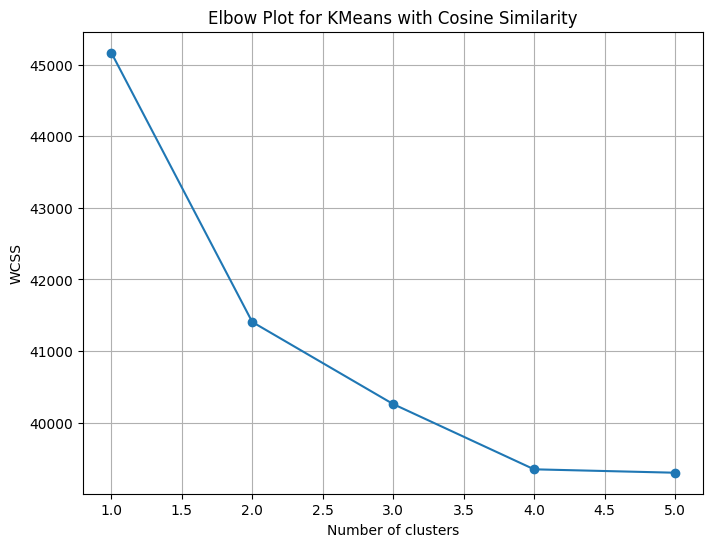

In [58]:
# Kmeas clustering using the cosine similarity
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def kmeans_cosine_elbow(data, max_clusters=5):
    # Calculate cosine similarity matrix using your custom function
    similarity_matrix = np.zeros((len(data), len(data)))  # Initialize similarity matrix
    for i in range(len(data)):
        for j in range(i, len(data)):  # Fill upper triangular matrix for efficiency (avoid duplicates)
            similarity_matrix[i, j] = adjusted_cosine_similarity(data[i], data[j])
            similarity_matrix[j, i] = similarity_matrix[i, j]  # Fill lower triangular matrix for symmetry
    
    # List to store WCSS (Within-Cluster Sum of Squares) for different k values
    wcss = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)  # Set random state for reproducibility
        kmeans.fit(similarity_matrix)
        wcss.append(kmeans.inertia_)  # Inertia represents WCSS
    
    # Elbow plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-')
    plt.xlabel("Number of clusters")
    plt.ylabel("WCSS")
    plt.title("Elbow Plot for KMeans with Cosine Similarity")
    plt.grid(True)
    plt.show()
    
    # You can observe the elbow point in the plot to determine the optimal k
    
# Example usage (replace with your actual data)
data = list(user_rating_dictionary.values())[:1000]
kmeans_cosine_elbow(data)


In [61]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def kmeans_clustering_visualize(data, optimal_k):
    """
    Performs KMeans clustering with the specified k and visualizes the clusters.
    
    Args:
      data: A numpy array representing the user rating dictionaries.
      optimal_k: The chosen optimal number of clusters.
    """
    # Calculate cosine similarity matrix using your custom function (assuming it's defined)
    similarity_matrix = np.zeros((len(data), len(data)))
    for i in range(len(data)):
        for j in range(i, len(data)):
            similarity_matrix[i, j] = adjusted_cosine_similarity(data[i], data[j])
            similarity_matrix[j, i] = similarity_matrix[i, j]
    
    # Perform KMeans clustering with the chosen k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans.fit(similarity_matrix)
    
    # Get cluster labels for each data point
    return kmeans.labels_

# Example usage (replace with your actual data and optimal k)
data = list(user_rating_dictionary.values())[:1000]
optimal_k = 2  # Replace with your actual optimal k value

cluster_labels = kmeans_clustering_visualize(data, optimal_k)

In [62]:
print(cluster_labels)

[1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1
 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1
 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1
 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1
 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1
 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0
 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0
 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0
 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0
 0 1 0 0 1 1 0 1 1 0 0 1 

### Content-Based Filtering (CBF)
Leveraging Movie Genomes: Explain the concept of movie genomes and their potential for CBF.
Preprocessing movie genomes:
Extract relevant features from movie genomes (e.g., genres, actors, directors).
Convert textual features (genres) to numerical representations using techniques like one-hot encoding.
Building a CBF model:
Choose a machine learning algorithm (e.g., K-Nearest Neighbors, Naive Bayes) suitable for CBF.
Train the model on movie features and corresponding ratings.
Define a function to recommend movies similar to a specific movie based on the trained model.

### Evaluation
Since you're dealing with recommending movies, here are some commonly used metrics that assess different aspects of your recommender systems:

Mean Reciprocal Rank (MRR): This metric considers the rank of the first relevant recommendation in the list. A higher MRR indicates that relevant recommendations appear closer to the top of the list. Why it's useful: MRR prioritizes the importance of getting the most relevant item at the top of the recommendation list.

Precision@k: This metric measures the proportion of the top k recommendations that are actually relevant to the user. A higher precision indicates a higher accuracy in recommending relevant movies. Why it's useful: Precision@k allows you to assess the overall quality of the top k recommendations. You might choose a different value of k depending on how many recommendations you typically show to users.

Normalized Discounted Cumulative Gain (NDCG): This metric considers both the relevance and the ranking of recommended items. A higher NDCG indicates that the most relevant items are ranked higher in the list.

### get recommendation
User choice integration: Create a mechanism (e.g., input field) for users to choose their favorite superhero ("Batman" or "Superman").
Personalized recommendations:
Based on user choice and their movie rating history:
Utilize all three recommendation engines (user-based CF, movie-based CF, CBF) to generate movie recommendations.
Optionally, prioritize recommendations within the chosen superhero universe.

### Conclusion
Summarize findings: Discuss the performance of each recommendation engine based on the evaluation metrics.
Insights and limitations: Highlight insights gained about user preferences and limitations of the system.
Future directions: Suggest potential improvements or extensions to the project (e.g., hybrid recommendation systems, incorporating additional datasets).